In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [23]:
orientation_data_path = '/kaggle/input/parlamint/orientation-tr-train.tsv' 
orientation_data = pd.read_csv(orientation_data_path, sep='\t')

orientation_data['label'] = orientation_data['label'].astype(int)
orientation_data = orientation_data.dropna(subset=['text', 'text_en'])

In [24]:
orientation_data.head()

,id,speaker,sex,text,text_en,label
0,tr00000,ca2031caa4032c51980160359953d507,M,"Yeni yasama döneminin ülkemiz için, milletimiz...","Mr. President, dear lawmakers, I salute you, a...",1
1,tr00001,4cee0addb3c69f6866869b180f90d45f,M,"Sayın Başkan, değerli milletvekilleri; bugün, ...","Mr. President, members of lawmakers, as I spea...",1
2,tr00002,b3d7f76d74ec268492f8190ca123a6b2,M,"Sayın Başkanım, öncelikle yüce Meclisin Başkan...","Mr. President, I'm here to share with you the ...",1
3,tr00003,722efac7138c8197a9d1e97eed3a8b18,M,24’üncü Dönem Meclis Başkanlığına seçilmenizde...,"Mr. President, under the principles determined...",1
4,tr00004,be82a4ade406ec6774a0a2e38f6957e3,M,24’üncü Yasama Dönemimizin tüm milletvekilleri...,"Mr. President, dear lawmakers, I ask God's mer...",1


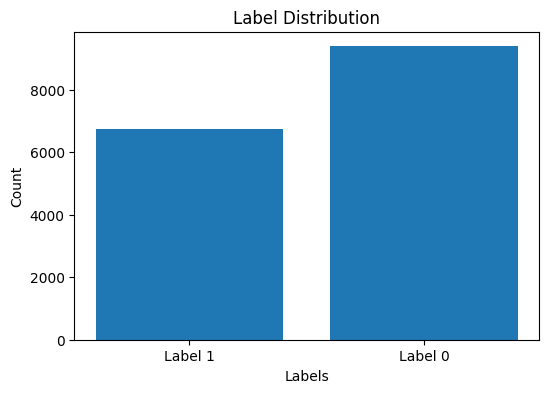

In [25]:
label_counts = orientation_data['label'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, tick_label=['Label 0', 'Label 1'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [26]:
power_data_path = '/kaggle/input/parlamint/power-tr-train.tsv' 
power_data = pd.read_csv(power_data_path, sep='\t')

power_data['label'] = power_data['label'].astype(int)
power_data = power_data.dropna(subset=['text', 'text_en'])

In [27]:
power_data.head()

,id,speaker,sex,text,text_en,label
0,tr18146,ca2031caa4032c51980160359953d507,M,"Yeni yasama döneminin ülkemiz için, milletimiz...","Mr. President, dear lawmakers, I salute you, a...",0
1,tr18147,4cee0addb3c69f6866869b180f90d45f,M,"Sayın Başkan, değerli milletvekilleri; bugün, ...","Mr. President, members of lawmakers, as I spea...",0
2,tr18148,b3d7f76d74ec268492f8190ca123a6b2,M,"Sayın Başkanım, öncelikle yüce Meclisin Başkan...","Mr. President, I'm here to share with you the ...",0
3,tr18149,722efac7138c8197a9d1e97eed3a8b18,M,24’üncü Dönem Meclis Başkanlığına seçilmenizde...,"Mr. President, under the principles determined...",0
4,tr18150,fcc61122f3553c57ae207adeb1a1af84,M,Usul tartışmasında 2 kişi lehte 2 kişi aleyhte...,"Two in favour of two in the legal debate, Mr. ...",1


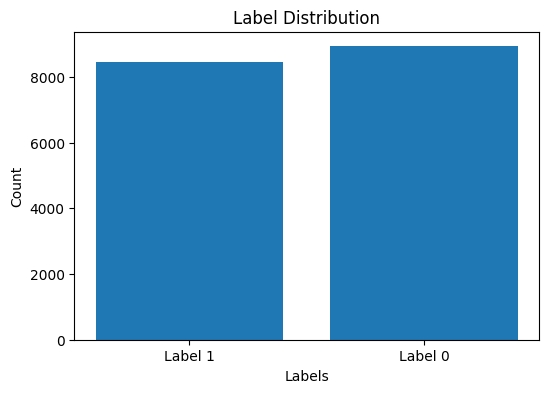

In [28]:
label_counts = power_data['label'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, tick_label=['Label 0', 'Label 1'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [29]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(orientation_data, orientation_data['label']):
    orientation_train_text = orientation_data.iloc[train_index]
    orientation_test_text = orientation_data.iloc[test_index]

In [30]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(power_data, power_data['label']):
    power_train_text = power_data.iloc[train_index]
    power_test_text = power_data.iloc[test_index]

In [31]:
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
def tokenize_function(examples, column_name):
    return tokenizer(examples[column_name], padding="max_length", truncation=True)

def prepare_dataset(df, column_name):
    dataset = Dataset.from_pandas(df)
    tokenized_dataset = dataset.map(lambda x: tokenize_function(x, column_name), batched=True)
    return tokenized_dataset

In [33]:
orientation_train_dataset_text = prepare_dataset(orientation_train_text, "text")
orientation_test_dataset_text = prepare_dataset(orientation_test_text, "text")

power_train_dataset_text_en = prepare_dataset(power_train_text, "text_en")
power_test_dataset_text_en = prepare_dataset(power_test_text, "text_en")

Map:   0%|          | 0/14524 [00:00<?, ? examples/s]

Map:   0%|          | 0/1614 [00:00<?, ? examples/s]

Map:   0%|          | 0/15645 [00:00<?, ? examples/s]

Map:   0%|          | 0/1739 [00:00<?, ? examples/s]

In [34]:
num_labels = 2  
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to("cuda")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/", 
    run_name="text_model_training",
    eval_strategy="epoch", 
    save_strategy="epoch",
    #logging_dir="./logs",       
    logging_steps=10, 
    learning_rate=2e-5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    num_train_epochs=3,              
    weight_decay=0.01,                
    save_total_limit=2,            
    load_best_model_at_end=True,  
    report_to="none",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [36]:
trainer_text = Trainer(
    model=model,
    args=training_args,
    train_dataset=orientation_train_dataset_text,
    eval_dataset=orientation_test_dataset_text,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer_text_en = Trainer(
    model=model,
    args=training_args,
    train_dataset=power_train_dataset_text_en,
    eval_dataset=power_test_dataset_text_en,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [37]:
print("Training text model on orientation dataset...")
trainer_text.train()

text_results = trainer_text.evaluate()
print("Orientation text model evaluation:", text_results)

Training text model on orientation dataset...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.420800,0.387408,0.829616,0.912935,0.781683,0.842226
2,0.257100,0.377679,0.844486,0.837255,0.909478,0.871873
3,0.279400,0.355264,0.859975,0.894795,0.860490,0.877307


Orientation text model evaluation: {'eval_loss': 0.355263888835907, 'eval_accuracy': 0.8599752168525403, 'eval_precision': 0.8947951273532669, 'eval_recall': 0.8604898828541001, 'eval_f1': 0.8773072747014115, 'eval_runtime': 15.1097, 'eval_samples_per_second': 106.819, 'eval_steps_per_second': 6.684, 'epoch': 3.0}


In [38]:
print("Training text_en model on power dataset...")
trainer_text_en.train()

text_en_results = trainer_text_en.evaluate()
print("Power text_en model evaluation:", text_en_results)

Training text_en model on power dataset...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.404800,0.382314,0.815986,0.920821,0.702461,0.796954
2,0.208700,0.337493,0.860840,0.889021,0.833333,0.860277
3,0.160100,0.354987,0.868890,0.879271,0.863535,0.871332


Power text_en model evaluation: {'eval_loss': 0.33749303221702576, 'eval_accuracy': 0.8608395629672225, 'eval_precision': 0.8890214797136038, 'eval_recall': 0.8333333333333334, 'eval_f1': 0.8602771362586605, 'eval_runtime': 16.2849, 'eval_samples_per_second': 106.786, 'eval_steps_per_second': 6.693, 'epoch': 3.0}
